In [158]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import uniform, norm, cauchy

# Přednáška 9: Monte Carlo, rejection sampling

## Motivační příklad

Nejprve malý skoro nematematický příklad, na intuici. Uvažujme, že máme kruh $\mathcal{K}$ o poloměru $r=1$. Víme, že jeho obsah je

$$
\mathcal{S}_{\mathcal{K}} = \pi r^2 = \pi,
$$

a chceme odhadnout hodnotu $\pi$. Vpíšeme tento kruh do čtverce $\mathcal{R}$ o straně $2r = 2$, viz obrázek.

<<< OBR >>>

Budeme-li předpokládat, že na tento obrazec dokonale rovnoměrně prší, jaká je pravděpodobnost, že kapka padne do kruhu? Velmi jednoduše - díky rovnoměrnosti deště - ji lze určit jako poměr plochy kruhu k ploše čtverce,

$$
P[x_i \in \mathcal{K}] 
= \frac{\mathcal{S}_{\mathcal{K}}}{\mathcal{S}_{\mathcal{R}}}
= \frac{\pi r^2}{2r \cdot 2r}
= \frac{\pi}{4}.
$$

Budeme tedy generovat náhodné vzorky z $\mathcal{U}_{[-1,1]\times[-1,1]}$ a zjišťovat, zda leží uvnitř kruhu nebo vně:

In [275]:
def estimate_pi(nsamples):
    samples = np.random.uniform(low=-1, high=1, size=(nsamples, 2))
    samples_dist_from_origin = np.sqrt((samples**2).sum(axis=1))
    samples_in_circle = np.sum(samples_dist_from_origin <= 1)
    probability = samples_in_circle / nsamples
    pi = 4 * probability
    return pi

nsamples = 10000
print('Estimate of pi: {0:.5f}'.format(estimate_pi(nsamples)))

Estimate of pi: 3.11480


## Monte Carlo integrace

Z analýzy víme, že integrál funkce $f(x)$ na intervalu $[a, b]$ je - velmi vágně řečeno - v podstatě součet malých obdélníků s výškou $f(x_i)$ a délkou strany $\Delta x$ (uvažujme shodná $\Delta x$),

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0} \sum_{i=1}^{N} f(x_i) \Delta x.
$$

Protože uvažujeme stejná $\Delta x$, můžeme je vytknout před sumu a rovnoměrně jimi rozdělit interval $[a,b]$ na $N$ podintervalů a vlastně se přesunout ke střední hodnotě funkce,

$$
\int_{a}^b f(x) dx \xleftarrow[N\to\infty]{\Delta x \to 0}  \sum_{i=1}^{N} f(x_i) \Delta x
= \frac{b-a}{N}\sum_{i=1}^{N} f(x_i) = V \frac{\sum_{i=1}^{N} f(x_i)}{N} = (b-a) \langle f \rangle,
$$

kde jsme označili střední hodnotu

$$
\langle f \rangle = \frac{\sum_{i=1}^{N} f(x_i)}{N}
$$

a "objem" (angl. volume) množiny $V = b - a$.

### Vícerozměrný případ

Obecně $M$-rozměrný případ je pouze analogií k jednorozměrnému. Pracujeme s integrálem funkce proměnné $x = [x_1, \ldots, x_M]$ a body $x_i = [x_{i,1}, \ldots, x_{i,M}]$,

$$
\int_{a_1}^{b_1} \cdots \int_{a_M}^{b_M} f(x) dx 
\xleftarrow[N\to\infty]{}
\frac{(b_1 - a_1) \cdots (b_M - a_M)}{N_1 \cdots N_M} \sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)
= V \langle f \rangle,
$$

kde $V = (b_1 - a_1) \cdots (b_M - a_M)$ je objem množiny a $\langle f \rangle = \frac{\sum_{i_1 = 1}^{N_1} \cdots \sum_{i_M=1}^{N_M} f(x_i)}{N_1 \cdots N_M}$ je střední hodnota funkce.

## Monte Carlo integrace

Základní ("naivní") Monte Carlo integrace využívá výše vyložený princip s tím, že body $x_i$ nebere jako **deterministicky stanovené body v rovnoměrně rozdělené síti**, ale **vybírá tyto body náhodně z rovnoměrného rozdělení**. Středování (průměrem) i objem množiny zůstávají zachovány. Zákon velkých čísel potom zajišťuje, že pro vzorky $x_i$ kde $i=1,\ldots,N$ nám Monte Carlo odhad integrálu konverguje ke skutečné hodnotě při $N\to \infty$. Konkrétně, pro varianci střední hodnoty funkce platí

$$
\mathrm{Var}(f) = \sigma_N^2 = \frac{1}{N}\sum_{i=1}^N (f(x_i) - \langle f \rangle)^2,
$$

a tedy variance odhadu integrálu

$$
\mathrm{Var}(V \langle f \rangle) = \frac{V^2}{N^2}\sum_{i=1}^N \operatorname{Var}(f) = V^2 \frac{\sigma_N^2}{N}.
$$

Z toho plyne, že pro $N\to\infty$ konverguje $\mathrm{Var}(V \langle f \rangle)$ - a tedy chyba odhadu - k nule.

## Odhad $\pi$ podruhé - integrací

Víme, že plocha jednotkového kruhu je $S = \pi r^2 = \pi$. Protože chceme pracovat s funkcí, bude výhodné uvažovat jen první kvadrant, jehož plocha je $S_{\frac{1}{4}} = \frac{\pi}{4}$. V prvním kvadrantu pro body na jednotkové kružnici tvořící hranici kruhu platí, že $x^2 + y^2 = r^2 = 1$ a tedy $y = \sqrt{r^2 - x^2} = \sqrt{1 - x^2}$. A plocha pod touto funkcí je rovněž 1/4 plochy kruhu. Tedy

$$
S_{\frac{1}{4}} = \frac{\pi}{4} = \int_{0}^{1} \sqrt{1-x^2}dx \qquad\text{z čehož plyne}\qquad
\pi = 4 \int_{0}^{1} \sqrt{1-x^2}dx.
$$

Algoritmus bude následující:
   1. Vygenerujeme N náhodných vzorků $x_i \sim \mathcal{U}(0, 1)$.
   2. Spočteme střední hodnotu integrované funkce přes všechna $x_i$, tedy $\langle f \rangle = \frac{1}{N} \sum_{i=1}^{N} \sqrt{1-x_i^2}$.
   3. Objem $V = 1 \cdot 1 = 1$.
   4. $\pi = 4 \cdot V \langle f \rangle$.

In [276]:
np.set_printoptions(precision=4)
@np.vectorize
def pi_mc_integration(nsamples):
    xi = np.random.uniform(0, 1, size=nsamples)
    fxi = np.sqrt(1 - xi**2)
    mean = np.mean(fxi)
    return 4 * mean

nsamples = np.power(10, range(8))
pi_estimates = pi_mc_integration(nsamples)
print(np.c_[nsamples, pi_estimates])

[[  1.0000e+00   3.9428e+00]
 [  1.0000e+01   3.2107e+00]
 [  1.0000e+02   3.0627e+00]
 [  1.0000e+03   3.1500e+00]
 [  1.0000e+04   3.1433e+00]
 [  1.0000e+05   3.1444e+00]
 [  1.0000e+06   3.1419e+00]
 [  1.0000e+07   3.1415e+00]]


## Rejection sampling (accept-reject alg.)

V bayesovské teorii se často setkáváme s komplikovanými aposteriorními distribucemi vyjadřujícími odhad hledané veličiny (parameteru). V dřívějších přednáškách jsme se tomuto jevu elegantně vyhýbali používáním *konjugovaných apriorních distribucí*. Pokud ovšem nechceme nebo nemůžeme konjugované apriorno použít, potřebujeme se stále nějak dopracovat k vlastnostem aposteriorní distribuce, například k její střední hodnotě apod. Pokud se nechceme nebo nemůžeme zaobírat analytickými metodami a aproximacemi, můžeme využít Monte Carlo vzorkování, z aposteriorna nagenerovat hromadu vzorků a spočítat z nich jeho přibližné vlastnosti. 

Jednou z nejjednodušších metod je tzv. **rejection sampling**, známý též jako accept-reject algoritmus. Ten využívá tzv. proposal distribuci (český ekvivalent?), což je nějaká vhodná distribuce, z níž umíme snadno vzorkovat (nebo na to máme vhodný software). 

Označme $f(x)$ hustotu, z níž chceme vzorkovat. Algoritmus je postaven na tom, že

$$
f(x) = \int_0^{f(x)} du = \int_0^1 \underbrace{\mathbb{1}_{0<u<f(x)}}_{f(x,u)}du.
$$

Vidíme, že na $f$ je možné nahlížet jako na marginálníá hustotu sdružené distribuce

$$
(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}.
$$

> **Základní teorém vzorkování (Fundamental theorem of simulation)**: Vzorkování $x\sim f(x)$ je ekvivalentní k vzorkování $(x, u) \sim \mathcal{U}\{(x, u): 0 < u < f(x)\}$.

Tento teorém nejde využít přímo, ale je možné jít oklikou: Navzorkovat $(x, u)$ z větší množíny a vybrat takové dvojice, pro něž je podmínka $0 < u < f(x)$ splněna.

### Algoritmus
Předpokládejme, že $\int_a^b f(x)dx = 1$ a zvolme $m > f(x)$ pro všechna $x\in[a,b]$. Vzorkujeme $(x', u) \sim \mathcal{U}(0<u<m)$ tak, že:
   1. Navzorkujeme $x' \sim \mathcal{U}(a, b)$,
   2. navzorkujeme $u|x=x' \sim \mathcal{U}(0, m)$,
   3. vzorek přijmeme, pokud $0<u<f(x')$.

### Příklad

V následujícím příkladu budeme generovat vzorky z N(0, 1) na intervalu [-4, 4]. Vykreslíme si histogram a vzorky.

% acceptance: 0.2633 (79 of 300)


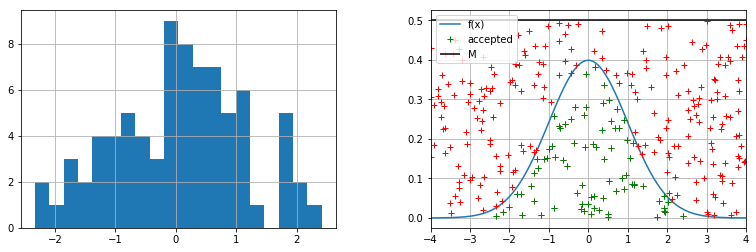

In [277]:
nsamples = 300     ### Number of samples
M = .5             ### M

samples_u = np.random.uniform(low=0., high=M, size=nsamples)   # uniform samples
samples_x = np.random.uniform(-4, 4, size=nsamples)            # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
accepted = np.where(samples_u < fx)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_x, samples_u, 'r+')
plt.plot(samples_x[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()

Výše uvedený algoritmus je pěkný, ale šel by výrazně vylepšit. Vzorkovat totiž můžeme rovnou přes množinu

$$
\mathcal{L} = \{(x', u): 0 < u < m(x')\}\qquad\text{kde}\qquad m(x) \geq f(x).
$$

Funkce $m(x)$ zjevně není hustotou (proč?). Můžeme ale využít nějaký vhodný **proposal** $g(x)$, který hustotou bude, a vhodné kladné číslo $M>0$ a nastavit

$$
m(x) = M g(x).
$$

### Algoritmus
   1. Navzorkujeme $x' \sim g$,
   2. navzorkujeme $u \sim \mathcal{U}(0, 1)$,
   3. vzorek $x'$ přijmeme, pokud $u\leq \frac{f(x')}{Mg(x')}$.

### Příklad

V následujícím příkladě budeme generovat vzorky z normálního rozdělení N(0, 1) pomocí Cauchyho proposalu. Histogram by měl odpovídat realizacím z normálního rozdělení. Vykreslíme stejně jako v přechozím případě pro interval [-4, 4], ale důležité je, že vzorky (z většiny zamítnuté) jsou i mimo tento interval. Pokud bychom chtěli jen uvedený interval, museli bychom použít ořezanou Cauchyho distribuci (truncated Cauchy), ta však není standardní.

% acceptance: 0.5267 (158 of 300)


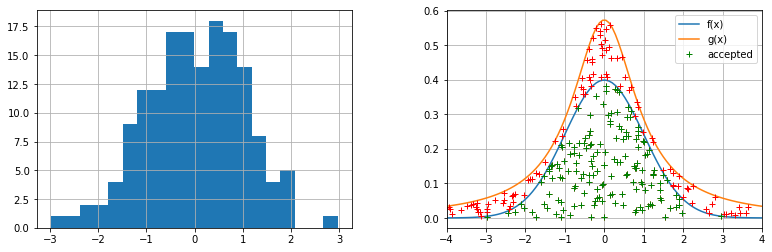

In [278]:
nsamples = 300     ### Number of samples
M = 1.8            ### M

samples_u = np.random.uniform(low=0., high=1., size=nsamples)  # uniform samples
samples_x = cauchy.rvs(size=nsamples)                          # proposal samples
fx = norm.pdf(samples_x)                                       # value of f(x)
ratio = fx / (M * cauchy.pdf(samples_x))
accepted = np.where(samples_u < ratio)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-4, 4, 100)
plt.plot(x, norm.pdf(x), label='f(x)')
plt.plot(x, M*cauchy.pdf(x), '-', label='g(x)')
plt.plot(samples_x, M*cauchy.pdf(samples_x)*samples_u, 'r+')
plt.plot(samples_x[accepted], M*cauchy.pdf(samples_x[accepted])*samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()

Lze snadno ukázat, že pravděpodobnost přijetí vzorku je $1/M$, proto čím blíže je $M$ k vzorkované hustotě, tím vyšší četnost přijatých vzorků.

Rejection sampling je mnohem efektivnější, než "naivní" výše vyložené Monte Carlo. Má ale také své nedostatky, např. s efektivitou v oblastech, kde je hustota koncentrována na malou podmnožinu, nebo naopak tam, kde nabývá velmi nízkých hodnot a většina vzorků není přijata. Ukážeme si to na první metodě, druhá metoda je mírně příznivější, ale velmi závislá na vhodném nastavení.

% acceptance: 0.0100 (3 of 300)


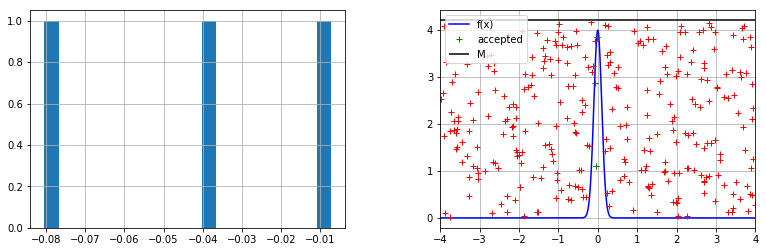

In [279]:
nsamples = 300     ### Number of samples
M = 4.2            ### M

samples_u = np.random.uniform(low=0., high=M, size=nsamples)   # uniform samples
samples_x = np.random.uniform(-4, 4, size=nsamples)            # proposal samples
fx = norm.pdf(samples_x, scale=.1)                             # value of f(x)
accepted = np.where(samples_u < fx)[0]

print("% acceptance: {0:.4f} ({1} of {2})".format(accepted.size/nsamples, accepted.size, nsamples))
plt.figure(figsize=(13, 4))
plt.subplot(121)
plt.hist(samples_x[accepted], bins=20)
plt.subplot(122)
x = np.linspace(-4, 4, 1000)
plt.plot(x, norm.pdf(x, scale=.1), 'b', label='f(x)')
plt.hlines(M, x.min(), x.max(), label='M')
plt.plot(samples_x, samples_u, 'r+')
plt.plot(samples_x[accepted], samples_u[accepted], 'g+', label='accepted')
plt.xlim(-4, 4)
plt.legend()
plt.show()